# Losses Tutorial

This tutorial demonstrates how to configure and run a **multi-link redundancy loss analysis** in Python using RA2CE.
While the Damages analysis estimates direct physical repair costs, the Losses analysis quantifies the **economic (indirect) impacts** of service disruption on users of the network.

The losses analysis builds on the **criticality of the road network** and translates disruptions into **Vehicle Loss Hours (VLH)**, which are then converted into **monetary values (€)** using traffic data and values of time.

## Required Inputs

Inputs required include:

- **Criticality** of each road link (alternative route length/time).
- **Resilience curve**: how quickly traffic recovers on a disrupted link.
- **Traffic intensities**: how many vehicles use each link, per time period and purpose.
- **Values of time**: the economic value (€/hour) of travel time for different trip purposes.

These input are all necessary to perform a losses analysis. The criticality analysis is automatically performed as part of the losses workflow and does not require further attention in this tutorial. Step 3 explains how to prepare the other required input data.

The output is expressed as:

- **Vehicle Loss Hours (VLH)** → total hours of lost accessibility due to disruptions.
- Broken down per **trip purpose** (commute, freight, business, etc.) and **time of day** (daily, rush hour, etc.), but also aggregated totals.

This makes the Losses module essential for answering questions like:

- *"What is the expected economic loss due to a non-availability of a road network from a natural hazard (e.g. flood event) ?"*
- *"What is the Expected Annual Loss (EAL) from repeated hazard events with different return periods?"*

## Step 1: Project Setup

We start by defining the root project directory and paths for input/output data:

In [ ]:
from pathlib import Path

root_dir = Path("data", "losses")

static_path = root_dir.joinpath("static")
hazard_path = static_path.joinpath("hazard")
output_path = root_dir.joinpath("output")
input_analysis_path = root_dir.joinpath("input_analysis_data")  # This is a path where input data for the losses analysis is stored

## Step 2: Define the Network

We configure the **network section** by providing the shapefile with road links.

The losses analysis requires specific additional data (e.g., traffic intensity for every link).
Therefore, it is **not recommended** to use OSM data for this analysis, as it would be difficult to collect all required input data for every OSM link.
We strongly recommend using a pre-defined shapefile as source for the road network.

It is essential to specify a unique `file_id` (e.g., `ID`), which corresponds to a unique identifier in the network shapefile.
This will later be used in Step 3 to match traffic intensities with the corresponding road links.

In [ ]:
from ra2ce.network.network_config_data.enums.network_type_enum import NetworkTypeEnum
from ra2ce.network.network_config_data.enums.source_enum import SourceEnum
from ra2ce.network.network_config_data.network_config_data import NetworkSection

network_section = NetworkSection(
    directed=False,
    source=SourceEnum.SHAPEFILE,
    primary_file=static_path.joinpath("network", 'network.shp'),
    file_id="ID",  # Needed for matching with traffic intensity
    save_gpkg=True,
    reuse_network_output=True,
)


We now specify the hazard data. The hazard maps (e.g., flood depth rasters) are read as GeoTIFFs.

The losses analysis provides results solely for road links (node to node) and not on segmented networks (every 100m for example). Therefore, we set `overlay_segmented_network=False` to speed up computational time.

In [ ]:
from ra2ce.network.network_config_data.enums.aggregate_wl_enum import AggregateWlEnum
from ra2ce.network.network_config_data.network_config_data import HazardSection

hazard_section = HazardSection(
    hazard_map=[Path(file) for file in hazard_path.glob("*.tif")],
    aggregate_wl=AggregateWlEnum.MAX,      # use maximum water level for losses
    hazard_crs="EPSG:32736",               # CRS of flood maps
    overlay_segmented_network=False
)

Both the network and hazard sections are passed to a single configuration object:

In [ ]:
from ra2ce.network.network_config_data.network_config_data import NetworkConfigData

network_config_data = NetworkConfigData(
    root_path=root_dir,
    network=network_section,
    hazard=hazard_section,
    static_path=root_dir.joinpath("static"),
)


## Step 3: Prepare required input data

Three CSV input files are required for the losses workflow:

| **File** | **Content** |
|----------|-------------|
| `resilience_curve.csv` | Recovery speed of road links after disruption (0–1 scale). |
| `traffic_intensities.csv` | Traffic volumes per link, per trip purpose, per period. |
| `values_of_time.csv` | Economic value of time per trip purpose (€/hour). |

These files have to be placed in the same folder as `input_analysis_path` defined in step 1. They will be added next step in [AnalysisSectionLosses](../api/ra2ce.analysis.analysis_config_data.html#ra2ce.analysis.analysis_config_data.analysis_config_data.AnalysisSectionLosses){.api-ref}.

### Traffic Intensity

The **traffic intensity** CSV file contains the average number of vehicles for every link in the network.
A distinction can be made between different trip purposes (e.g., commute, freight, business, other)
and time periods (e.g., day, evening) since the traffic patterns can vary significantly throughout the day.

The traffic intensity must be expressed in **number of vehicles per day**.

The traffic intensity can be differentiated between classes of trips. You have to choose among the
pre-defined trip purposes from [TripPurposeEnum](../api/ra2ce.analysis.analysis_config_data.enums.html#ra2ce.analysis.analysis_config_data.enums.trip_purpose_enum.TripPurposeEnum){.api-ref} (`BUSINESS`, `COMMUTE`, `FREIGHT`, `OTHER`) and use the following structure for column names:
`day_typeoftrip` or `evening_typeoftrip`.

For example:

| **ID** | **evening_commute** | **evening_freight** | **evening_total** | **day_commute** | **day_freight** | **day_total** |
|--------|---------------------|---------------------|-------------------|-----------------|-----------------|---------------|
| 1      | 0                   | 0                   | 0                 | 100             | 200             | 300           |
| 2      | 0                   | 0                   | 0                 | 50              | 20              | 70            |
| 3      | 10                  | 2                   | 12                | 30              | 32              | 62            |

### Values of time

As a user, you also need to specify the **value of time** for every class of trip defined in the traffic intensity.
It represents the amount of money lost per unit of time (or distance) due to the unavailability of a disrupted link.

The value of time can be expressed either:
- per **hour of delay** (€/hour), or
- per **kilometer of detour** (€/km).

The unit of currency depends on the values entered in this table, but must be consistent across all rows.

The **average number of occupants per vehicle** is also required for each trip purpose. This is especially important to compute the losses for links without alternative routes.

Example (`values_of_time.csv`):

| **trip_types** | **value_of_time** | **occupants** |
|----------------|-------------------|---------------|
| commute        | 10                | 1             |
| freight        | 20                | 2             |

In this example, vehicles in the *commute* class experience an economic loss of **10 €/hour of disruption**, while *freight* vehicles lose **20 €/hour**, with two occupants per vehicle.

### Resilience Curves

The last required input file defines the **resilience curves** for the different road types in the network.
Each road type (e.g., highway, residential) is affected differently by a given hazard level and recovers at its own pace.

The column `link_type_hazard_intensity` controls which resilience curve is selected for each road type and hazard level.
The hazard intensity uses the same unit as in the hazard map.
For example, for `highway_0-0.5`, the corresponding resilience curve applies to all links of type *highway* with a hazard intensity between 0 and 0.5.

The table must cover **all road types** and **all expected hazard intensities**.

The resilience curves are defined with:
- **duration steps** (in hours)
- **functionality loss ratio**

**Example interpretation** (first row of the table):
- At t = 0, the link is 100% functional
- Between t = 0 and t = 10 h, the link is 50% functional
- Between t = 10 h and t = 40 h (10+30), the link is 70% functional
- Between t = 40 h and t = 90 h (10+30+50), the link is 90% functional
- After t > 90 h, the link is fully functional again

| **link_type_hazard_intensity** | **duration_steps** | **functionality_loss_ratio** |
|--------------------------------|---------------------|------------------------------|
| highway_0-0.5                  | [10.0, 30.0, 50.0] | [0.5, 0.3, 0.1]             |
| highway_0.5-2                  | [10.0, 40.0, 100.0]| [0.75, 0.5, 0.25]           |
| residential_0-2                | [5.0, 10.0, 15.0]  | [0.75, 0.5, 0.25]           |

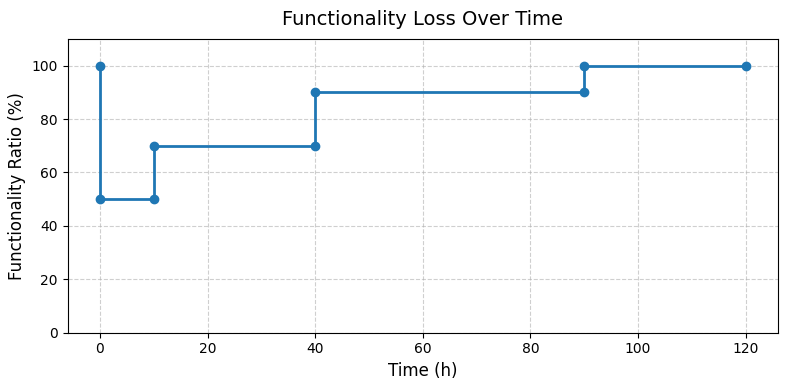

## Step 4: Define the Losses Analysis

Now we configure the **losses analysis** using [AnalysisSectionLosses](../api/ra2ce.analysis.analysis_config_data.html#ra2ce.analysis.analysis_config_data.analysis_config_data.AnalysisSectionLosses){.api-ref} and the analysis type set to [MULTI_LINK_LOSSES](../api/ra2ce.analysis.analysis_config_data.enums.html#ra2ce.analysis.analysis_config_data.enums.analysis_losses_enum.AnalysisLossesEnum.MULTI_LINK_LOSSES){.api-ref}.
It is required for this analysis to provide the three CSV input files prepared in Step 3, and to specify the **production loss per capita per hour** (in €/hour) as well as the traffic period ([TrafficPeriodEnum](../api/ra2ce.analysis.analysis_config_data.enums.html#module-ra2ce.analysis.analysis_config_data.enums.traffic_period_enum){.api-ref}) and trip purposes ([TripPurposeEnum](../api/ra2ce.analysis.analysis_config_data.enums.html#ra2ce.analysis.analysis_config_data.enums.trip_purpose_enum.TripPurposeEnum){.api-ref}) to consider.

In [ ]:
from ra2ce.analysis.analysis_config_data.analysis_config_data import (AnalysisConfigData, AnalysisSectionLosses)
from ra2ce.analysis.analysis_config_data.enums.analysis_losses_enum import AnalysisLossesEnum
from ra2ce.analysis.analysis_config_data.enums.trip_purpose_enum import TripPurposeEnum
from ra2ce.analysis.analysis_config_data.enums.weighing_enum import WeighingEnum
from ra2ce.analysis.analysis_config_data.enums.event_type_enum import EventTypeEnum
from ra2ce.analysis.analysis_config_data.enums.traffic_period_enum import TrafficPeriodEnum

losses_analysis = [AnalysisSectionLosses(
    name='losses',
    analysis=AnalysisLossesEnum.MULTI_LINK_LOSSES,  # MULTI_LINK_LOSSES or SINGLE_LINK_LOSSES
    event_type=EventTypeEnum.EVENT,                 # EVENT-based analysis (single hazard event)
    weighing=WeighingEnum.TIME,                     # losses weighted by time (instead of length)
    threshold=0.5,                                  # water depth threshold for disruption
    production_loss_per_capita_per_hour=42,
    traffic_period=TrafficPeriodEnum.DAY,
    trip_purposes=[
        TripPurposeEnum.BUSINESS,
        TripPurposeEnum.COMMUTE,
        TripPurposeEnum.FREIGHT,
        TripPurposeEnum.OTHER,
    ],

    # CSV input files
    resilience_curves_file=input_analysis_path.joinpath("resilience_curve.csv"),
    traffic_intensities_file=input_analysis_path.joinpath("traffic_intensities.csv"),
    values_of_time_file=input_analysis_path.joinpath("values_of_time.csv"),

    save_csv=True,
    save_gpkg=True
)]

analysis_config_data = AnalysisConfigData(
    analyses=losses_analysis,
    output_path=output_path,
)

## Step 5: Run the Analysis

Finally, we create a RA2CE handler, configure the analysis, and run it:

In [ ]:
from ra2ce.ra2ce_handler import Ra2ceHandler

handler = Ra2ceHandler.from_config(network_config_data, analysis_config_data)

handler.configure()
handler.run_analysis()

## Output

The results are saved in the `output` folder as:

- **losses.gpkg** → GeoPackage with results per link

The attributes of interest include:

- `vlh_RP10_ma_total` → Loss (in €) for hazard event RP10, all trip purposes aggregated
- `vlh_commute_RP10_ma` → Loss (in €) for hazard event RP10, commute trips only
- `vlh_freight_RP10_ma` → Loss (in €) for hazard event RP10, freight trips only
- `vlh_business_RP10_ma` → Loss (in €) for hazard event RP10, business trips only
- `vlh_other_RP10_ma` → Loss (in €) for hazard event RP10, other trips only